## Softmax回归

回归是估计一个连续值，分类是预测一个离散值。

如果我们有n个类别的话，我们可以对其进行一位有效编码。我们的标号就是一个长为n的标号：$\mathbf{y}=\left[y_{1}, y_{2}, \ldots, y_{n}\right]^{\top}$。

最大值为预测值：

$$
\hat{y}=\underset{i}{\operatorname{argmax}} o_{i}
$$

我们需要使得，正确的类的置信度$o_{y}$要远远大于其它非正确类的置信度$o_{i}$：

$$
o_{y}-o_{i} \geq \Delta(y, i)
$$

我们还期望输出是一个概率(非负，和为1)。

$$
\begin{aligned}
\hat{\mathbf{y}} &=\operatorname{softmax}(\mathbf{o}) \\
\hat{y}_{i} &=\frac{\exp \left(o_{i}\right)}{\sum_{k} \exp \left(o_{k}\right)}
\end{aligned}
$$

### Softmax和交叉熵

一般来说，我们用交叉熵来衡量两个概率之间的区别：$H(\mathbf{p}, \mathbf{q})=\sum_{i}-p_{i} \log \left(q_{i}\right)$。

如果将其当作损失的话，就是如下形式：

$$
l(\mathbf{y}, \hat{\mathbf{y}})=-\sum_{i} y_{i} \log \hat{y}_{i}=-\log \hat{y}_{y}
$$

可以看出，对于分类问题来说，我们不关心非正确类的预测值，我们只关心对于正确类的预测值有多大。

其梯度就是真实概率和预测概率之间的区别：

$$
\partial_{o_{i}} l(\mathbf{y}, \hat{\mathbf{y}})=\operatorname{softmax}(\mathbf{o})_{i}-y_{i}
$$




softmax回归是一个多分类模型，使用softmax操作子可以得到每个类的预测置信度。最后我们使用一个交叉熵来衡量预测和标号之间的区别。

## 损失函数

### 均方损失

$L_{2}$损失：

$$
l\left(y, y^{\prime}\right)=\frac{1}{2}\left(y-y^{\prime}\right)^{2}
$$

### 绝对值损失

$L_{1}$损失：

就是预测值减去真实值：

$$
l\left(y, y^{\prime}\right)=\left|y-y^{\prime}\right|
$$

### Huber‘s Robust Loss

$$
l\left(y, y^{\prime}\right)= \begin{cases}|y-y| \mid-\frac{1}{2} & \text { if }\left|y-y^{\prime}\right|>1 \\ \frac{1}{2}\left(y-y^{\prime}\right)^{2} & \text { otherwise }\end{cases}
$$

当预测值和真实值差距比较大的时候，是一个绝对值误差。当预测值和真实值靠地比较近的时候，就是一个平方误差。


In [2]:
import numpy as np
import time
# from function import *
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
sns.set()

ModuleNotFoundError: No module named 'sklearn.cross_validation'

## 图像分类数据集

MINIST数据集是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。我们将使用类似但更复杂的Fashion-MNIST数据集

In [1]:
%matplotlib inline
import torch
import torchvision # pytorch对于计算机视觉实现的一些库。
from torch.utils import data
from torchvision import transforms # 对数据进行操作的transforms
import sys
sys.path.append("..")
from d2l import torch as d2l

d2l.use_svg_display() # 使用svg显示图片，清晰度高一点。

### 读取数据集

我们可以通过框架中的内置函数将 Fashion-MNIST 数据集下载并读取到内存中。

In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()  # 将图片转成Pytorch中的tensor格式。
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-wdh4qigd/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Fashion-MNIST 由 10 个类别的图像组成，每个类别由训练数据集中的 6000 张图像和测试数据集中的 1000 张图像组成。测试数据集（test dataset）不会用于训练，只用于评估模型性能。训练集和测试集分别包含 60000 和 10000 张图像。

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
print(mnist_train[0][0].shape)  # 第0个样本的特征shape。
print(mnist_train[0][1]) # 第0个样本的标号。

torch.Size([1, 28, 28])
9


Fashion-MNIST中包含的10个类别分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数用于在数字标签索引及其文本名称之间进行转换。

In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 
                   'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前几个样本的图像及其相应的标签（文本形式）。

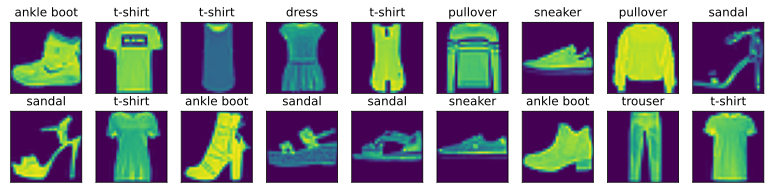

In [7]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

### 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建一个。 回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为batch_size。我们在训练数据迭代器中还随机打乱了所有样本。

In [8]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据。"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

### 整合所有组件

现在我们定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集。它返回训练集和验证集的数据迭代器。此外，它还接受一个可选参数，用来将图像大小调整为另一种形状。

In [9]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))  # 可以通过transforms来使得图片变得更大一点。
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

下面，我们通过指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能。

In [10]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## softmax回归从零开始实现

就像我们从零开始实现线性回归一样，我们认为softmax回归也是重要的基础，因此你应该知道实现softmax的细节。

In [11]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

将展平每个图像，将他们视为长度为784的向量。因为我们的数据集有10个类别，所以网络输出维度为10。

In [12]:
num_inputs = 784
num_outputs = 10
# 初始化w的值为高斯分布，均值为0，方差为0.01。
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 定义softmax操作

给定一个举证，我们可以对给定的轴上的元素求和

In [13]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

softmax由三个步骤组成：

1. 对每个项求幂；
2. 对每一行求和，得到每个样本的诡异话常数；
3. 将每一行除以其归一化常数，确保结果的和为1；

In [14]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

正如你所看到的，对于任何随机输入，我们将每个元素变成一个非负数。此外，依据概率原理，每行总和为1。

In [15]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2194, 0.0307, 0.1224, 0.4114, 0.2161],
         [0.1201, 0.5531, 0.1246, 0.1538, 0.0483]]),
 tensor([1.0000, 1.0000]))

### 实现softmax回归模型

In [16]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 交叉熵损失

创建一个数据y_hat，其中包含2个样本在3个类别的预测概率，使用y作为y_hat中概率的索引：

In [17]:
y = torch.tensor([0, 2])  # 创建两个真实的标号。
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # 预测值
y_hat[[0, 1], y]  # 对第0个样本拿出y0对应的那个样本，对第1个样本拿出y1对应的那个样本的输出。

tensor([0.1000, 0.5000])

实现交叉熵损失函数

In [18]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类准确率

将预测类别与真实y元素进行比较

In [19]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # 保证y_hat是一个二维矩阵。
        y_hat = y_hat.argmax(axis=1)  # 每一行中最大的值的下标存起来。
    cmp = y_hat.type(y.dtype) == y  # y_hat转成y的数据类型，然后作比较。
    return float(cmp.type(y.dtype).sum())

In [20]:
accuracy(y_hat, y) / len(y)

0.5

同样，对于任意数据迭代器 data_iter 可访问的数据集，我们可以评估在任意模型 net 的准确率。

In [21]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

这里 Accumulator 是一个实用程序类，用于对多个变量进行累加。 在上面的 evaluate_accuracy 函数中，我们在 Accumulator 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量。当我们遍历数据集时，两者都将随着时间的推移而累加。

In [22]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [23]:
evaluate_accuracy(net, test_iter)

0.0587

### softmax回归训练

In [24]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）。"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序类。

In [25]:
from IPython import display
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

接下来我们实现一个训练函数，它会在train_iter 访问到的训练数据集上训练一个模型net。该训练函数将会运行多个迭代周期（由num_epochs指定）。在每个迭代周期结束时，利用 test_iter 访问到的测试数据集对模型进行评估。我们将利用 Animator 类来可视化训练进度。

In [26]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

作为一个从零开始的实现，我们使用之前定义的小批量随机梯度下降来优化模型的损失函数，设置学习率为0.1。

In [27]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

现在，我们训练模型10个迭代周期。请注意，迭代周期（num_epochs）和学习率（lr）都是可调节的超参数。通过更改它们的值，我们可以提高模型的分类准确率。

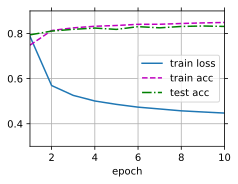

In [28]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

现在训练已经完成，我们的模型已经准备好对图像进行分类预测。给定一系列图像，我们将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。

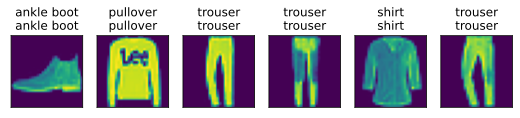

In [29]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## softmax回归的简洁实现

通过深度学习框架的高级API能够使实现softmax回归变得更加容易

In [30]:
import torch
from torch import nn
from d2l import torch as d2l


batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

softmax回归的输出层是一个全连接层

In [31]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数

In [32]:
loss = nn.CrossEntropyLoss()

使用学习率为0.1的小批量随机梯度下降作为优化算法

In [33]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

调用之前定义的训练函数来训练模型

训练

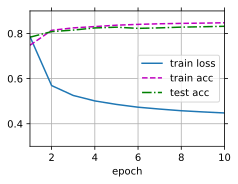

In [34]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 问答

1. 老师能提一下softlabel训练策略吗？以及为什么有效。

很难用指数去逼近一个1，想要逼近1的话，就需要输出接近无穷。softlabel就是将正确的那一类变成0.9，非正确的那一类变成0.1，这样做的好处是使用softmax去拟合0.9和0.1的时候是有可能的。

这个是图片分类里面大家默认会使用的一个小trick。

2. softmax回归和logistic回归分析是一样的吗？

可以认为是一样的，当只有两类的时候，就不需要归一化，正类的概率为1的时候，负类别概率就是1-y。

3. 为什么使用交叉熵，不用相对熵、互信息等其他的基于信息的度量？

最大的原因在于不好算，没有交叉熵算地简单。

4. $y * log(\hat{y})$我们为什么只关心正确类，不关心不正确类呢，如果关心不正确类效果有没有可能更好呢？

其实不是不关心，只不过是在计算两个分布之间差异的时候，会将其值变为0。如果我们使用softlabel的话，就会关心到不正确的类上。

5. 这样的n分类，对每一个类别来说，是不是可以认为只有1个正类，n-1个负类，会不会类别不平衡呢？

会有这种情况，但是如果使用softmax的话，并不会考虑其他类。

6. MSE和最大似然

最小化损失等价于最大化似然函数。
